<a href="https://colab.research.google.com/github/fernandofsilva/thesis/blob/main/Notebook_Options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup 

In [ ]:
import pandas as pd
import numpy as np
import math

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('darkgrid')

ticker = 'VALE3'
mode = 'DNN'

# Load data

Load data quotes from all symbols

In [ ]:
raw_data = pd.read_csv('/content/drive/My Drive/Datasets/cotacao.csv.gz')
raw_data.head()

,TIPREG,DATPRG,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,MODREF,PREABE,PREMAX,PREMIN,PREMED,PREULT,PREOFC,PREOFV,TOTNEG,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES
0,1,2015-01-02,2,AAPL34,10,APPLE,DRN,NaN,R$,29.65,29.65,29.45,29.61,29.45,29.20,0.00,2,32300,9.564350e+05,0.0,0,9999-12-31,1,0,BRAAPLBDR004,111
1,1,2015-01-02,2,ABCB4,10,ABC BRASIL,PN EJS N2,NaN,R$,12.85,12.85,12.35,12.54,12.55,12.55,12.56,531,117100,1.469337e+06,0.0,0,9999-12-31,1,0,BRABCBACNPR4,123
2,1,2015-01-02,96,ABCB4F,20,ABC BRASIL,PN EJS N2,NaN,R$,12.83,12.83,12.48,12.69,12.48,12.53,12.86,5,208,2.641260e+03,0.0,0,9999-12-31,1,0,BRABCBACNPR4,123
3,1,2015-01-02,12,ABCP11,10,FII ABC IMOB,CI ER,NaN,R$,9.72,9.72,8.01,9.64,9.64,9.31,9.64,9,496,4.781490e+03,0.0,0,9999-12-31,1,0,BRABCPCTF000,231
4,1,2015-01-02,2,ABEV3,10,AMBEV S/A,ON EJ,NaN,R$,16.14,16.56,15.77,16.08,16.01,15.91,16.01,21543,19110800,3.073420e+08,0.0,0,9999-12-31,1,0,BRABEVACNOR1,106


## Spot data

In [ ]:
# Filter data from VALE3
spot = raw_data[raw_data['CODNEG'] == ticker]

# Dict to rename the columns
dict_ref = {
    'DATPRG': 'date',
    'PREULT': 'S',
    'VOLTOT': 'volume'
}

# Rename the columns and subset
spot = spot.rename(columns=dict_ref)
spot = spot[dict_ref.values()]

# Format and subset date
spot['date'] = pd.to_datetime(spot['date'])
spot = spot.sort_values(by='date')
spot.index = spot['date']
spot = spot.drop(['date'], axis=1)

spot.head()

,S,volume
date,,
2015-01-02,21.28,120672152.0
2015-01-05,20.96,173776434.0
2015-01-06,21.80,212788714.0
2015-01-07,22.60,135618045.0
2015-01-08,22.84,104941063.0


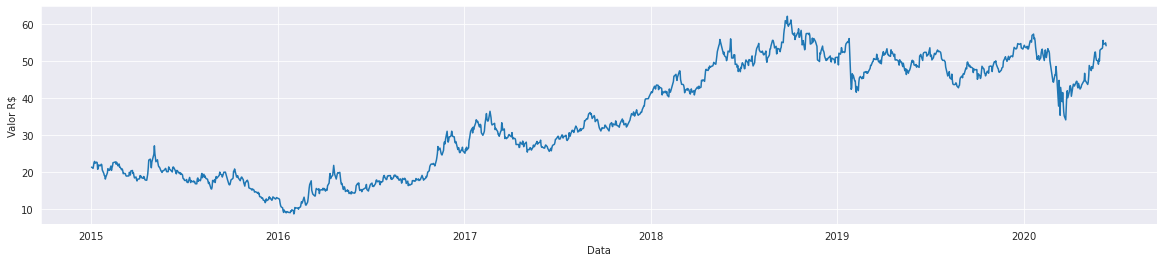

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(spot['S'])
ax.set_ylabel('Valor R$')
ax.set_xlabel('Data')
plt.show()

## Options

### Filter Options data

In [ ]:
# Dict to rename the columns
dict_ref = {
    'DATPRG': 'date',
    'CODNEG': 'option',
    'PREULT': 'value',
    'PREEXE': 'X',
    'DATVEN': 'expire',
    'TPMERC': 'option_type'
}

# Rename the columns
option = raw_data.rename(columns=dict_ref)

# Filter options data
option = option[option['option_type'].isin([70, 80])]
option = option[option['option'].str.startswith(ticker[:-1])]
option = option[dict_ref.values()]

# Dict symbol type
TPMERC = {70: 'call', 80: 'put'}

# Replace options types
option['option_type'] = option['option_type'].replace(TPMERC)
option.head()

,date,option,value,X,expire,option_type
1266,2015-01-02,VALEA15,2.98,15.85,2015-01-19,call
1267,2015-01-02,VALEA17,2.25,16.85,2015-01-19,call
1268,2015-01-02,VALEA18,1.28,17.85,2015-01-19,call
1269,2015-01-02,VALEA19,0.44,19.10,2015-01-19,call
1270,2015-01-02,VALEA20,0.18,19.85,2015-01-19,call


### T calculation

In [ ]:
# Get unique days
workday = pd.DataFrame({'day': option['date'].unique()})
workday['day'] = pd.to_datetime(workday['day'])
workday = workday.sort_values(by='day')

# Create T
T = list()

for index, row in option.iterrows():
    T.append(workday[(workday['day'] >= row.date) & (workday['day'] <= row.expire)].shape[0] - 1)

option['T'] = T
option['T'] = option['T'] / 252

# Format and subset date
option['date'] = pd.to_datetime(option['date'])
option['expire'] = pd.to_datetime(option['expire'])
option = option.sort_values(by='date')

# Set index
option.index = option['date']
option = option.drop(['date'], axis=1)

option.head()

,option,value,X,expire,option_type,T
date,,,,,,
2015-01-02,VALEA15,2.98,15.85,2015-01-19,call,0.043651
2015-01-02,VALEM45,0.01,14.35,2015-01-19,put,0.043651
2015-01-02,VALEM44,0.01,14.85,2015-01-19,put,0.043651
2015-01-02,VALEM32,11.46,30.35,2015-01-19,put,0.043651
2015-01-02,VALEM20,1.14,19.85,2015-01-19,put,0.043651


### Reference Dataframe

In [ ]:
# Get list with unique expire date
l = option['expire'].sort_values().unique()

# Create empty dataframe
reference = pd.DataFrame()

# Loop over the list
for index, (start, end) in enumerate(zip(l, l[1:])):

    # Count number of days between dates
    aux = pd.DataFrame(
        {'start': [start],
         'end': [end],
         'count': [workday[(workday['day'] >= start) & (workday['day'] < end)].shape[0]]},
         index=[index]
    )
    
    # Append in the dataframe
    reference = reference.append(aux)

reference = reference[reference['count'] >= 18]

reference.head()

,start,end,count
1,2015-02-09,2015-03-16,23
2,2015-03-16,2015-04-20,24
3,2015-04-20,2015-05-18,18
4,2015-05-18,2015-06-15,19
5,2015-06-15,2015-07-20,24


### Filter data

In [ ]:
option_data = pd.DataFrame()

for index, row in reference.iterrows():

    # Select data according expire date
    aux = option[option['expire'] == row['end']]

    # Select data within the month
    aux = aux[row['start']:row['end']]

    # Count the number of day the options were trade
    count = aux.groupby(by=['option'], as_index=False).agg({'value': 'count'})

    # Select options that were traded every day in the period
    symbols = count.loc[count['value'] == row['count'], 'option']

    # Filter with just options were traded every day in the period
    aux = aux[aux['option'].isin(symbols)]

    # Get last 18 days
    for symbol in aux['option'].unique():
        
        # Append data of the last 18 days befores expire date
        option_data = option_data.append(aux[aux['option'] == symbol].iloc[-18:,:])

option_data.head()

,option,value,X,expire,option_type,T
date,,,,,,
2015-02-18,VALEO14,0.03,14.35,2015-03-16,put,0.071429
2015-02-19,VALEO14,0.02,14.35,2015-03-16,put,0.067460
2015-02-20,VALEO14,0.02,14.35,2015-03-16,put,0.063492
2015-02-23,VALEO14,0.03,14.35,2015-03-16,put,0.059524
2015-02-24,VALEO14,0.02,14.35,2015-03-16,put,0.055556


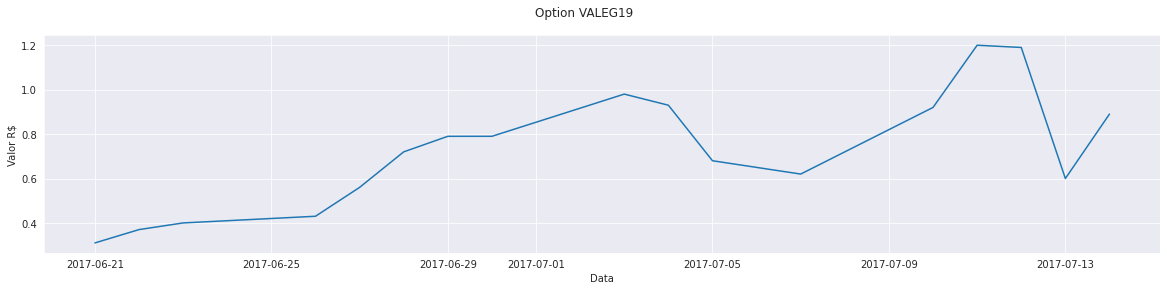

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Option VALEG19')
ax.plot(option_data.loc[(option_data['option'] == 'VALEG19') & (option_data['expire'] == '2017-07-17'), 'value'])
ax.set_ylabel('Valor R$')
ax.set_xlabel('Data')
plt.show()

## CDI

In [ ]:
cdi = pd.read_csv('/content/drive/My Drive/Datasets/cdi.csv', usecols=['date', 'cdi'])

# # Format and subset date
cdi['date'] = pd.to_datetime(cdi['date'], format='%d/%m/%y')
cdi = cdi.sort_values(by='date')

# Filter using the first date
cdi = cdi[cdi['date'].dt.month != cdi['date'].dt.month.shift(1)]

In [ ]:
# Create date range
date = pd.DataFrame({'date': pd.date_range(start='1/1/2015', end='12/31/2020')})

# Merge with cdi
date = date.merge(right=cdi, how='left', on='date')

# Fill Nan
date['cdi'] = date['cdi'].fillna(method='ffill')
cdi = date.dropna()

In [ ]:
# Create index
cdi = cdi.rename(columns={'cdi': 'r'})
cdi.index = cdi['date']
cdi = cdi.drop(['date'], axis=1)
cdi.head()

,r
date,
2015-01-02,11.57
2015-01-03,11.57
2015-01-04,11.57
2015-01-05,11.57
2015-01-06,11.57


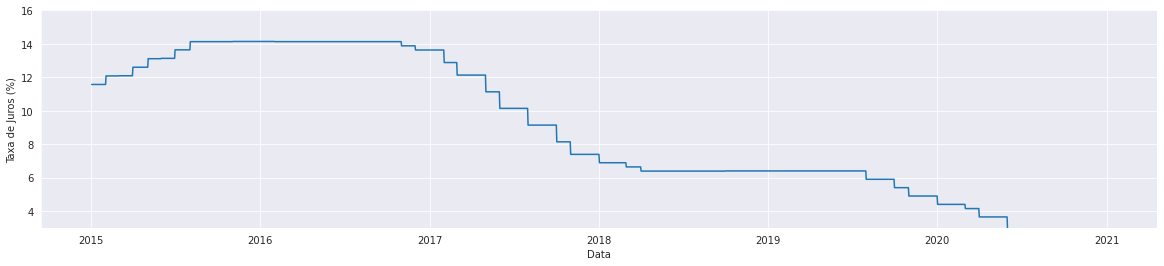

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(cdi)
ax.set_ylabel('Taxa de Juros (%)')
ax.set_ylim(3, 16)
ax.set_xlabel('Data')
plt.show()

## Data Merge

In [ ]:
# Merge data
if mode == 'DNN':
    data = option.merge(right=spot, right_index=True, left_index=True)
else:
    data = option_data.merge(right=spot, right_index=True, left_index=True)

data = data.merge(right=cdi, right_index=True, left_index=True)
data.head()

,option,value,X,expire,option_type,T,S,volume,r
date,,,,,,,,,
2015-01-02,VALEA15,2.98,15.85,2015-01-19,call,0.043651,21.28,120672152.0,11.57
2015-01-02,VALEM45,0.01,14.35,2015-01-19,put,0.043651,21.28,120672152.0,11.57
2015-01-02,VALEM44,0.01,14.85,2015-01-19,put,0.043651,21.28,120672152.0,11.57
2015-01-02,VALEM32,11.46,30.35,2015-01-19,put,0.043651,21.28,120672152.0,11.57
2015-01-02,VALEM20,1.14,19.85,2015-01-19,put,0.043651,21.28,120672152.0,11.57


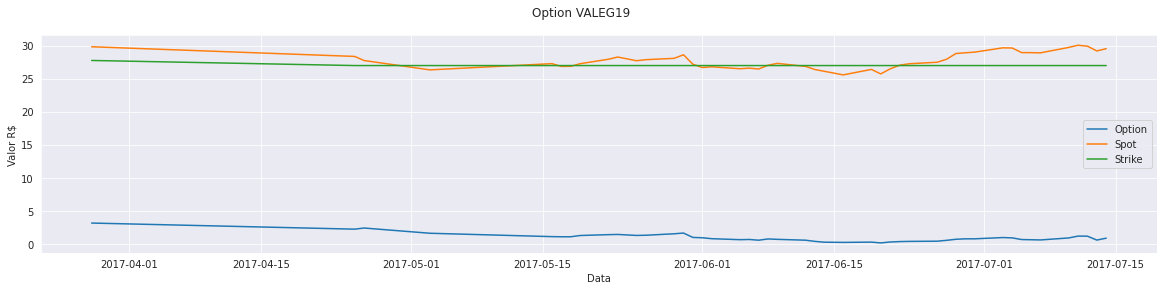

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Option VALEG19')
ax.plot(data.loc[(data['option'] == 'VALEG19') & (data['expire'] == '2017-07-17'), 'value'], label='Option')
ax.plot(data.loc[(data['option'] == 'VALEG19') & (data['expire'] == '2017-07-17'), 'S'], label='Spot')
ax.plot(data.loc[(data['option'] == 'VALEG19') & (data['expire'] == '2017-07-17'), 'X'], label='Strike')
ax.set_ylabel('Valor R$')
ax.set_xlabel('Data')
ax.legend()
plt.show()

# GARCH (1,1)

## Returns

In [ ]:
spot['return'] = np.log(spot['S'] / spot['S'].shift(1))
spot = spot.dropna()
spot['var'] = spot['return']**2
spot.head()

,S,volume,return,var
date,,,,
2015-01-05,20.96,173776434.0,-0.015152,0.000230
2015-01-06,21.80,212788714.0,0.039294,0.001544
2015-01-07,22.60,135618045.0,0.036040,0.001299
2015-01-08,22.84,104941063.0,0.010563,0.000112
2015-01-09,22.35,80426260.0,-0.021687,0.000470


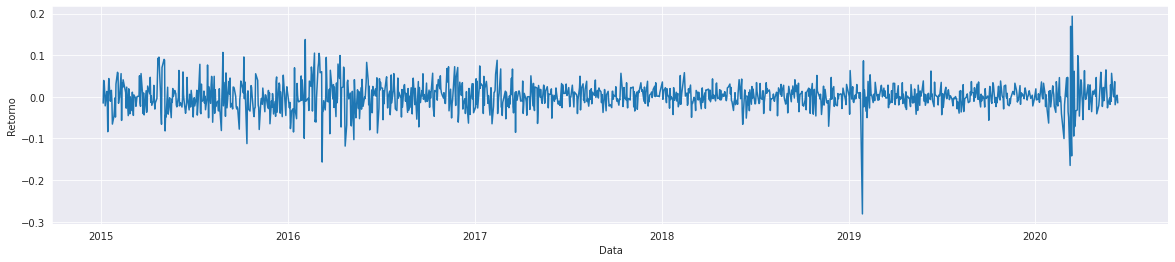

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(spot['return'])
ax.set_ylabel('Retorno')
ax.set_xlabel('Data')
plt.show()

## GARCH (with a Constant Mean)

In [ ]:
from arch import arch_model

am = arch_model(spot['return'], p=1, o=0, q=1)
res = am.fit(update_freq=5)
garch = res.conditional_volatility * math.sqrt(252) * 100
garch = garch.rename("sigma")
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2811.1712433775374
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                2811.17
Distribution:                  Normal   AIC:                          -5614.34
Method:            Maximum Likelihood   BIC:                          -5593.53
                                        No. Observations:                 1343
Date:                Sun, Nov 01 2020   Df Residuals:                     1339
Time:                        22:28:00   Df Model:                            4
                                  Mean Model                                 
 

### Plot

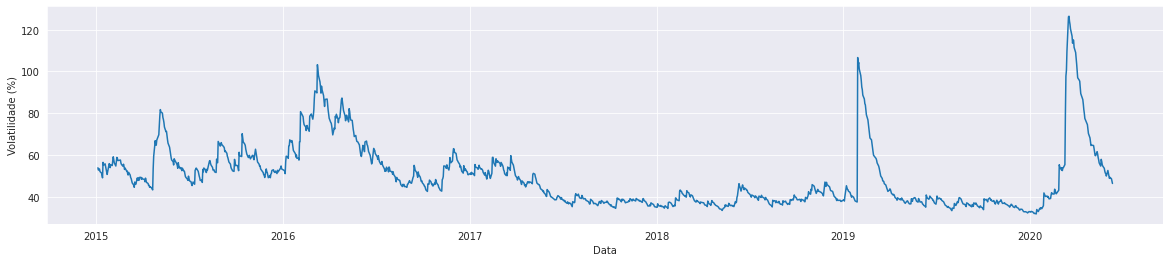

In [ ]:
fig, axs = plt.subplots(figsize=(20, 4))
axs.plot(garch)
axs.set_ylabel('Volatilidade (%)')
axs.set_xlabel('Data')
plt.show()

In [ ]:
data = data.merge(right=garch, right_index=True, left_index=True)
data = data.rename(columns={'cond_vol': 'vol'})
data.head()

,option,value,X,expire,option_type,T,S,volume,r,sigma
date,,,,,,,,,,
2015-01-05,VALEM18,0.27,17.85,2015-01-19,put,0.039683,20.96,173776434.0,11.57,53.922216
2015-01-05,VALEM19,0.86,19.10,2015-01-19,put,0.039683,20.96,173776434.0,11.57,53.922216
2015-01-05,VALEM20,1.44,19.85,2015-01-19,put,0.039683,20.96,173776434.0,11.57,53.922216
2015-01-05,VALEM32,12.00,30.35,2015-01-19,put,0.039683,20.96,173776434.0,11.57,53.922216
2015-01-05,VALEM47,0.06,16.35,2015-01-19,put,0.039683,20.96,173776434.0,11.57,53.922216


# Black-Scholes

In [ ]:
from scipy.stats import norm

# Auxiliary function for d_one risk-adjusted probability
def d11(S, X, T, r, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))

# Auxiliary function for d_two risk-adjusted probability
def d21(d1, T, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return d1 - sigma * np.sqrt(T)

# Definition of the Black-Scholes delta function
def bs_delta(S, X, T, r, sigma, option_type):
    """Compute the delta of the Black-Scholes option pricing formula.

    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'

    Returns: a numpy.float_ representing the delta value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    if option_type == 'call':
        return norm.cdf(d11(S, X, T, r, sigma))
    elif option_type == 'put':
        return norm.cdf(-d11(S, X, T, r, sigma))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

# Definition of the Black-Scholes European option pricing formula
def black_scholes(S, X, T, r, sigma, option_type):
    """Price a European option using the Black-Scholes option pricing formula.

    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'

    Returns: a numpy.float_ representing the option value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    d_one = d11(S, X, T, r, sigma)
    d_two = d21(d_one, T, sigma)
    if option_type == 'call':
        return S * norm.cdf(d_one) - np.exp(-r * T) * X * norm.cdf(d_two)
    elif option_type == 'put':
        return -(S * norm.cdf(-d_one) - np.exp(-r * T) * X * norm.cdf(-d_two))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

def bs_pandas(row):
    value = black_scholes(
        row['S'], row['X'], row['T'], row['r']/100, row['sigma']/100, row['option_type']
    )
    return round(value, 2)

def delta_pandas(row):
    value = bs_delta(
        row['S'], row['X'], row['T'], row['r']/100, row['sigma']/100, row['option_type']
    )
    return int(round(value * 100, 0))

In [ ]:
def newton_vol_call(S, K, T, C, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #C: Call value
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    fx = S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0) - C
    
    vega = (1 / np.sqrt(2 * np.pi)) * S * np.sqrt(T) * np.exp(-(norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    
    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
        
    while abs(xnew - xold) > tolerance:
    
        xold = xnew
        xnew = (xnew - fx - C) / vega
        
        return abs(xnew)

def newton_vol_put(S, K, T, P, r, sigma):
    
    d1 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    fx = K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0) - P
    
    vega = (1 / np.sqrt(2 * np.pi)) * S * np.sqrt(T) * np.exp(-(norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    
    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
        
    while abs(xnew - xold) > tolerance:
    
        xold = xnew
        xnew = (xnew - fx - P) / vega
        
        return abs(xnew)

def imp_vol(row):
    if row['option_type'] == 'call':
        return newton_vol_call(row['S'], row['X'], row['T'], row['value'], row['r']/100, row['sigma']/100) * 100
    else:
        return newton_vol_put(row['S'], row['X'], row['T'], row['value'], row['r']/100, row['sigma']/100) * 100

In [ ]:
data['bs'] = data.apply(bs_pandas, axis=1)
data['delta_bs'] = data.apply(delta_pandas, axis=1)
data['imp_vol'] = data.apply(imp_vol, axis=1)

data.head()

,option,value,X,expire,option_type,T,S,volume,r,sigma,bs,delta_bs,imp_vol
date,,,,,,,,,,,,,
2015-01-05,VALEM18,0.27,17.85,2015-01-19,put,0.039683,20.96,173776434.0,11.57,53.922216,0.06,6,70.295437
2015-01-05,VALEM19,0.86,19.10,2015-01-19,put,0.039683,20.96,173776434.0,11.57,53.922216,0.21,17,76.433360
2015-01-05,VALEM20,1.44,19.85,2015-01-19,put,0.039683,20.96,173776434.0,11.57,53.922216,0.40,27,69.433512
2015-01-05,VALEM32,12.00,30.35,2015-01-19,put,0.039683,20.96,173776434.0,11.57,53.922216,9.25,100,522.851771
2015-01-05,VALEM47,0.06,16.35,2015-01-19,put,0.039683,20.96,173776434.0,11.57,53.922216,0.01,1,57.709577


In [ ]:
import numpy as np
from scipy.stats import norm
N = norm.cdf

def bs_call(S, K, T, r, vol):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, *args):
    MAX_ITERATIONS = 200
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

# Save to file

In [ ]:
# Filter to the last valid expire date
data = data[data['expire'] <= '2020-05-18']

In [ ]:
# cols = ['option', 'S', 'X', 'T', 'r', 'sigma', 'option_type', 'value']
data.to_csv(f'/content/drive/My Drive/Datasets/data_option_{ticker}_{mode}.csv')
data.to_excel(f'/content/drive/My Drive/Datasets/data_option_{ticker}_{mode}.xlsx')